# OFDM signal (better resampling)

Install all dependencies

In [1]:
!pip install numpy matplotlib scipy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter, filtfilt, resample
from calculate_evm import calculate_evm

Define flags to control code flow

In [3]:
manual_filtering = True
manual_phase_compensation = True
zero_phase_filtering = False

Calculate modulation symbols (64QAM)

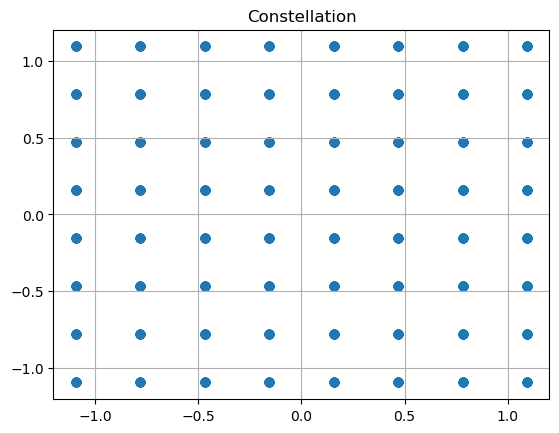

In [4]:
number_of_symbols = 2048
symbol_re = np.random.randint(0, 8, number_of_symbols) * 2 - 7 
symbol_im = np.random.randint(0, 8, number_of_symbols) * 2 - 7 
golden_symbols = symbol_re + 1.0j * symbol_im
golden_symbols = golden_symbols / np.sqrt(np.mean(np.abs(golden_symbols) ** 2)) 
plt.figure()
plt.grid()
plt.scatter(np.real(golden_symbols), np.imag(golden_symbols))
plt.title("Constellation")
plt.show()

Add noise

In [5]:
symbols = golden_symbols
add_noise = False
if add_noise:
    SNR_dB = 23
    SNR_linear = 10 ** (SNR_dB / 10)
    noise_power = 1 / SNR_linear
    symbols = symbols + np.sqrt(noise_power / 2) * (np.random.randn(number_of_symbols) + 1.0j * np.random.randn(number_of_symbols))
    evm = calculate_evm(golden_symbols, symbols)
    print(f"The calculated EVM = {evm:.2f}%")
    plt.figure()
    plt.grid()
    plt.scatter(np.real(symbols), np.imag(symbols))
    plt.title("Noisy constellation")
    plt.show()

Generate OFDM signal (ignoring CP)

In [6]:
ofdm = np.fft.ifft(symbols)

Perform digital upconversion to carrier frequency

In [7]:
subcarrier_spacing = 15e3
fs_bb = number_of_symbols * subcarrier_spacing
interpolation_factor = 164
fs = fs_bb * interpolation_factor
fc = fs / 2.1
interpolation_factor = fs / fs_bb
print(f"number of symbols = {number_of_symbols}, "
      f"subcarrier spacing = {subcarrier_spacing / 1e3}kHz, "
      f"sampling frequency (baseband) = {fs_bb / 1e6:.2f}MHz, "
      f"carrier frequency = {fc / 1e9:.2f}GHz, "
      f"sampling frequency (carrier) = {fs / 1e9:.2f}GHz, "
      f"interpolation factor = {interpolation_factor}")
upsampled_ofdm = resample(ofdm, int(len(ofdm) * interpolation_factor))
print(f"number of samples before upsampling: {len(ofdm)}, "
      f"number of samples after upsampling: {len(upsampled_ofdm)}")
t = np.arange(len(upsampled_ofdm)) / fs
carrier_signal = np.exp(1.0j * 2 * np.pi * fc * t)
upconverted_signal = np.real(upsampled_ofdm * carrier_signal)

number of symbols = 2048, subcarrier spacing = 15.0kHz, sampling frequency (baseband) = 30.72MHz, carrier frequency = 2.40GHz, sampling frequency (carrier) = 5.04GHz, interpolation factor = 164.0
number of samples before upsampling: 2048, number of samples after upsampling: 335872


Perform digital downconversion using IQ sampling

In [8]:
downconverted_signal_i = upconverted_signal * np.cos(2 * np.pi * fc * t)
downconverted_signal_q = -upconverted_signal * np.sin(2 * np.pi * fc * t)
fcutoff = 1.1 * fs_bb
if manual_filtering:
    numtaps = 43
    coeffs = firwin(numtaps, fcutoff, fs = fs)
    downconverted_signal_i = lfilter(coeffs, 0.5, downconverted_signal_i)
    downconverted_signal_q = lfilter(coeffs, 0.5, downconverted_signal_q)
    if manual_phase_compensation:
        group_delay = (numtaps - 1) // 2
        downconverted_signal_i = np.roll(downconverted_signal_i, -group_delay)
        downconverted_signal_q = np.roll(downconverted_signal_q, -group_delay)
elif zero_phase_filtering:
    numtaps = 33
    coeffs = firwin(numtaps, fcutoff, fs = fs)
    downconverted_signal_i = filtfilt(coeffs, np.sqrt(0.5), downconverted_signal_i)
    downconverted_signal_q = filtfilt(coeffs, np.sqrt(0.5), downconverted_signal_q)
downconverted_signal = downconverted_signal_i + 1.0j * downconverted_signal_q
downsampled_signal = resample(downconverted_signal, len(ofdm))

Re-generate modulation symbols

Regenerated EVM = 0.66%


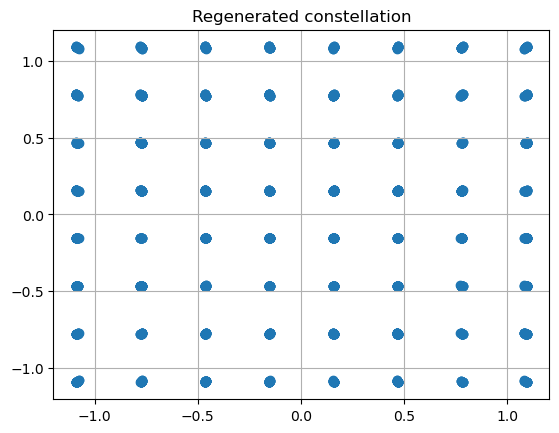

In [9]:
regenerated_symbols = np.fft.fft(downsampled_signal)
'''scaling_factor = np.sqrt(np.mean(np.abs(regenerated_symbols) ** 2 / np.abs(golden_symbols) ** 2))
print(f"scaling_factor = {scaling_factor:.2f}")'''
regenerated_evm = calculate_evm(golden_symbols, regenerated_symbols)
print(f"Regenerated EVM = {regenerated_evm:.2f}%")
plt.figure()
plt.grid()
plt.scatter(np.real(regenerated_symbols), np.imag(regenerated_symbols))
plt.title("Regenerated constellation")
plt.show()


All copyright reserved @2025 Ericsson